# Analysing Model Predictions

In this notebook, the model predictions from *ClassificationNanoparticles.ipynb* and *RegressionNanoparticles.ipynb* can be plotted and analysed. The main data to be analysed is the model's accuracy as the angle interval differs in the training and test dataset.

All of my work can be found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

# Importing the relevant libraries.

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

The data is loaded from and saved directly in Google Drive.

In [2]:
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path, force_remount=True)

cwd = os.path.join(drive_path, "MyDrive", "Nanoparticles")
folder_name = "Mixed Dataset W 12-14 RX 0-45 RY 0-45"
direc = os.path.join(cwd, folder_name)
results_direc = os.path.join(direc, "Results")

Mounted at /content/drive


# Analysing the model's accuracy.

First, the desired model, classification or regression, must be chosen to load in the correct .csv file.

In [3]:
model_types = ["Classification", "Regression"]
model_to_analyse = model_types[0]

The following class loads in the data from the .csv file. It then sorts the data to be plotted on a graph. This graph is then saved to Google Drive.

In [10]:
class analyse_shape:
  """
  This class analyses the .csv files from the different shapes in the specified
  dataset. The data is then plotted and saved.
  """
  def __init__(self, model_type, shape_name):
    """
    Initialise the class.

    Inputs:
      model_type: String, 'Classification' or 'Regression'
      shape_name: String, lattice shape to be analysed
    """
    self.model_type = model_type
    self.shape_name = shape_name

    self.results_direc = os.path.join(results_direc, "%s Results" % self.model_type, "%s" % self.shape_name)
    self.results_csv = os.path.join(self.results_direc, "%s %s Results.csv" % (self.model_type, self.shape_name))

    self.load_csv_data()
    self.plot_results()
    self.save_results()

  def load_csv_data(self):
    """
    Adds the .csv data to NumPy arrays to be plotted.
    """
    data = []
    configs = []

    with open(self.results_csv, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
            config = [row[0], row[1]]
            if config not in configs:
              configs.append(config)

    data.pop(0)
    configs.pop(0)
    self.data = np.asarray(data).astype(float)
    self.configs = np.asarray(configs).astype(float)

    avg_results = []

    for config in self.configs:
      counter = 0
      entries = []
      for result in self.data:
        if np.array_equal(config, result[0:2]):
          entries.append(result)
        
      entries = np.asarray(entries)
      avg_entries = np.mean(entries, axis=0)
      avg_results.append(avg_entries)

    self.avg_results = np.asarray(avg_results)
    self.shape_prediction_accuracy = np.mean(self.avg_results[:,-1])
    self.avg_results = self.sort_and_reshape_array(self.avg_results)

    print("Model predicted %s images with %s%% accuracy." % (self.shape_name, round(self.shape_prediction_accuracy * 100, 2)))

  def sort_and_reshape_array(self, avg_results):
    """
    Sorts the array by second column then first column and reshapes to plot as
    individual lines on a graph.

    Inputs:
      avg_results: NumPy array, array to be sorted
    
    Outputs:
      avg_results_ordered: NumPy array, sorted array
    """
    order = np.lexsort((avg_results[:,1], avg_results[:,0]))
    avg_results_ordered = avg_results[order]

    num_dr_test = np.unique(avg_results_ordered[:,0]).shape[0]
    num_dr_train = np.unique(avg_results_ordered[:,1]).shape[0]

    avg_results_ordered = np.reshape(avg_results_ordered, (num_dr_test, num_dr_train, avg_results_ordered.shape[-1]))
    return avg_results_ordered

  def plot_results(self):
    """
    Plot the .csv results.
    """
    drx = []
    dry = []

    self.fig_results = plt.figure(figsize=(20, 6.5))

    plt.subplot(121)

    for index in range(self.avg_results.shape[0]):
      rx = self.avg_results[index][:,2]
      plt.plot(self.avg_results[index][:,1], rx, c=(index / self.avg_results.shape[0], 0.2, 0.3), label='DR_TEST %s°' % self.avg_results[index][0][0])
      drx.append(rx)

    drx = np.asarray(drx)
    plt.hlines(np.mean(drx), np.min(self.avg_results[:,1]), np.max(self.avg_results[:,1]), colors='g', label="Mean difference in RX = %s°" % round(np.mean(drx), 2))
    plt.xlabel("Training dataset angle interval (°)", fontsize=16)
    plt.ylabel("Difference in angle (°)", fontsize=16)
    plt.xlim([np.min(self.avg_results[0][:,1]), np.max(self.avg_results[0][:,1])])
    plt.ylim([0, np.max(self.avg_results[:,1])])
    plt.legend(loc='best', fontsize=16)
    plt.title("Difference in RX", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.subplot(122)

    for index in range(self.avg_results.shape[0]):
      ry = self.avg_results[index][:,3]
      plt.plot(self.avg_results[index][:,1], ry, c=(index / self.avg_results.shape[0], 0.2, 0.3), label='DR_TEST %s°' % self.avg_results[index][0][0])
      dry.append(ry)

    dry = np.asarray(dry)
    plt.hlines(np.mean(dry), np.min(self.avg_results[:,1]), np.max(self.avg_results[:,1]), colors='g', label="Mean difference in RY = %s°" % round(np.mean(dry), 2))
    plt.xlabel("Training dataset angle interval (°)", fontsize=16)
    plt.xlim([np.min(self.avg_results[0][:,1]), np.max(self.avg_results[0][:,1])])
    plt.ylim([0, np.max(self.avg_results[:,1])])
    plt.legend(loc='best', fontsize=16)
    plt.title("Difference in RY", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.suptitle("%s Model | %s | Average Difference Between True and Predicted Rotation For Different Training and Testing Angle Intervals" % (self.model_type, self.shape_name), fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

    plt.show()
  
  def save_results(self):
    """
    Save the graph.
    """
    plot_name = "%s Rotation Results.png" % self.model_type
    self.fig_results.savefig(os.path.join(self.results_direc, plot_name))

# Visualising the model's accuracy.

The average absolute differences between the true and predicted angles are plotted versus different training and test angle intervals, separated into angle around the x-axis and y-axis.

Model predicted Octahedron images with 99.35% accuracy.


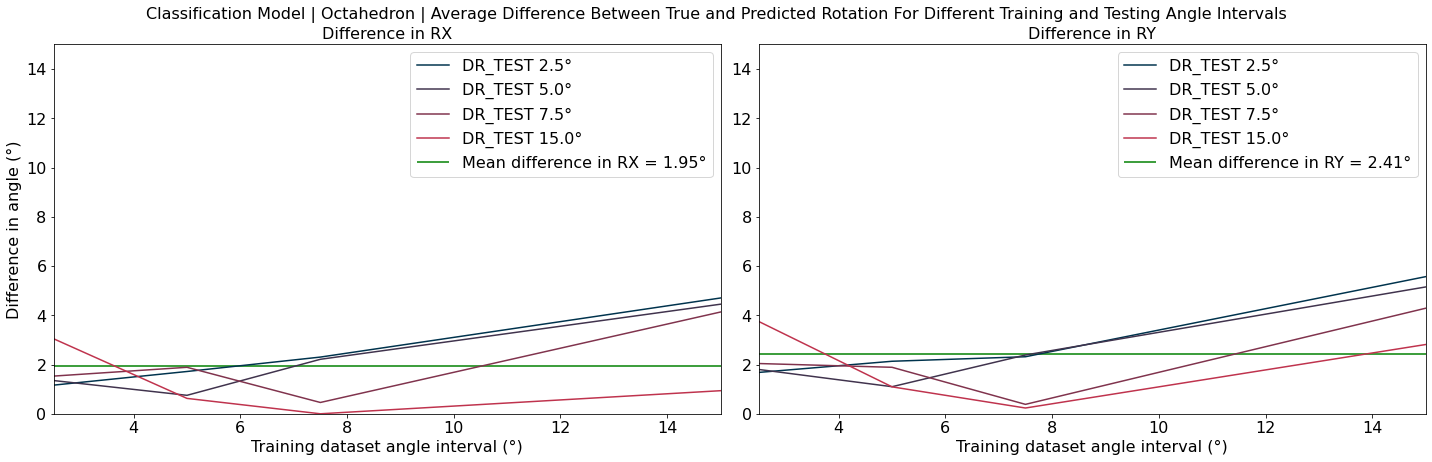

Model predicted Tetrahedron images with 99.42% accuracy.


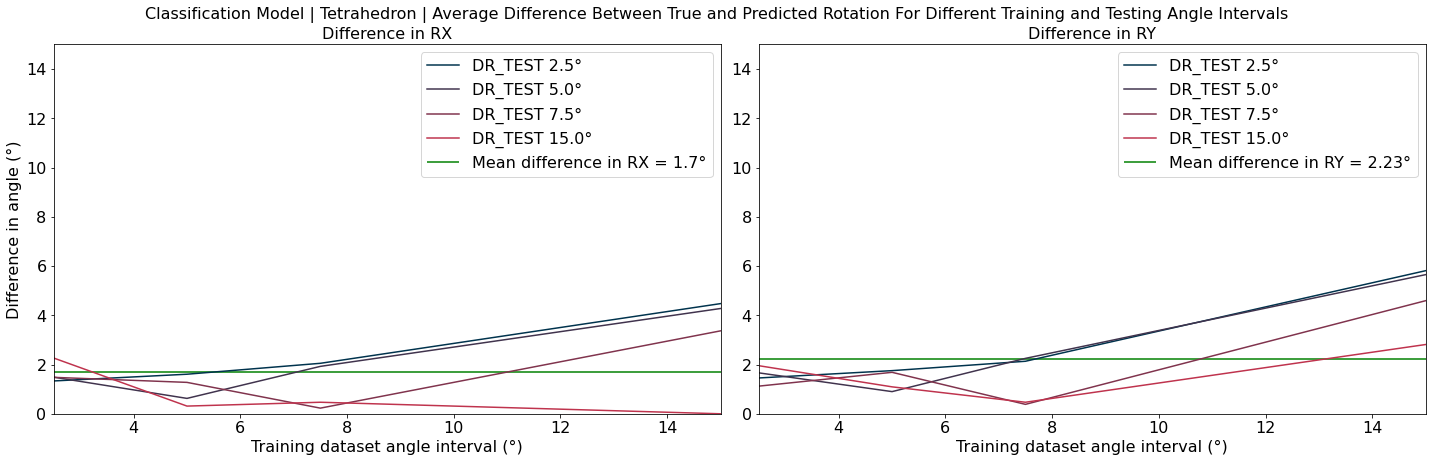

Model predicted Cube images with 99.85% accuracy.


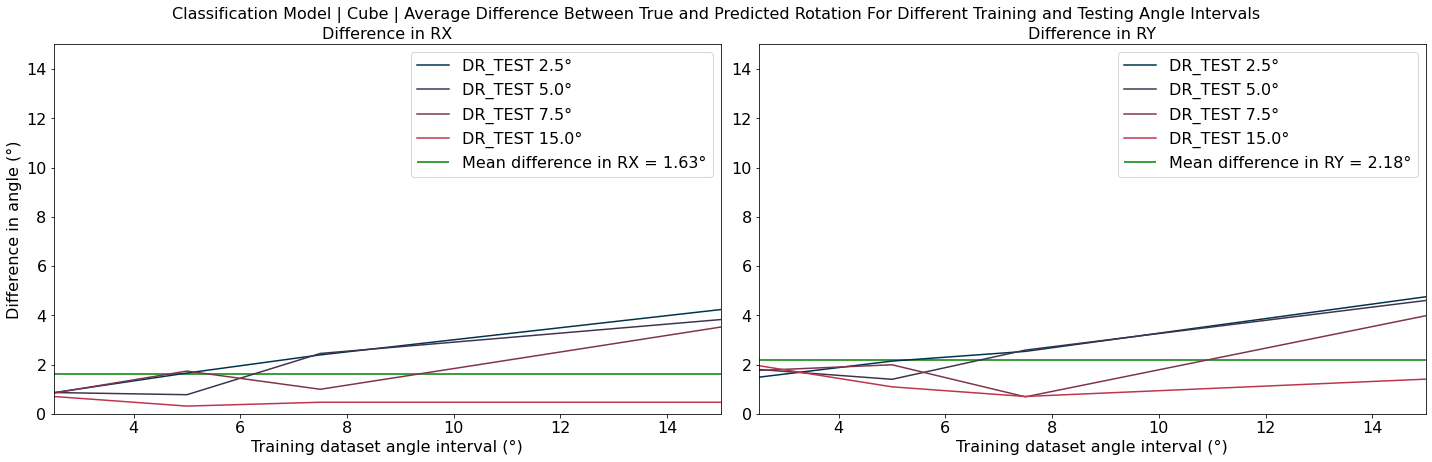

In [11]:
actual_shapes = []
folder_path = os.path.join(results_direc, "%s Results" % model_to_analyse)

for label in os.listdir(folder_path):
  if os.path.isdir(os.path.join(folder_path, label)):
    actual_shapes.append(label.split("_")[0])

for shape in actual_shapes:
  analyse_shape(model_to_analyse, shape)

The above graphs are saved to Google Drive.